In [1]:
from keypoint_network import (build_kpextractor64, 
                              build_kpextractor128, 
                              build_kpextractor64_decoupled,
                              build_kpextractor128_decoupled,
                              build_kpextractor128_decoupled_stn,
                              build_kpextractor256_decoupled,
                              preproc_dataset)
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join
import utool as ut

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
size = 128
model_loc = 'all_kpts_%d_fixedx' % size
dset_loc = 'all_kpts_%d_fixedx' % size

In [3]:
#model_name = 'dec_nest_a2e-3_e100.pkl'
#model_name = 'model_adam.pkl'
model_name = 'model.pkl'
with open(join(dataset_loc, "Flukes/kpts/%s" % join(model_loc, model_name)), 'r') as f:
    model = pickle.load(f)

dset = load_dataset(join(dataset_loc, "Flukes/kpts/%s" % dset_loc), normalize_method='zscore')

Loading /home/zach/data/Flukes/kpts/all_kpts_128_fixedx
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/meanstd.pkl')
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/train.pkl')
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/val.pkl')
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/test.pkl')
Took 0.24 seconds


In [4]:
X = T.tensor4()


kpextractor = build_kpextractor128_decoupled()
ll.set_all_param_values(kpextractor, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(kpextractor)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
kpextractor_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:kpextractor_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(kpextractor)],ll.get_all_params(kpextractor))))

[(0, ((1.0454679, (16, 1, 3, 3)), conv1.W)),
 (1, ((0.4156408, (16,)), conv1.b)),
 (2, ((0.071916886, (16,)), beta)),
 (3, ((0.56463158, (16,)), gamma)),
 (4, ((0.27300224, (16,)), mean)),
 (5, ((192.18637, (16,)), inv_std)),
 (6, ((1.8769455, (32, 16, 3, 3)), conv2.W)),
 (7, ((0.32175741, (32,)), conv2.b)),
 (8, ((0.096512996, (32,)), beta)),
 (9, ((0.66342103, (32,)), gamma)),
 (10, ((0.21103455, (32,)), mean)),
 (11, ((214.48235, (32,)), inv_std)),
 (12, ((2.783005, (64, 32, 3, 3)), conv3.W)),
 (13, ((0.4605116, (64,)), conv3.b)),
 (14, ((0.12691596, (64,)), beta)),
 (15, ((0.76322621, (64,)), gamma)),
 (16, ((0.14763528, (64,)), mean)),
 (17, ((485.44046, (64,)), inv_std)),
 (18, ((3.2168133, (128, 64, 3, 3)), conv4.W)),
 (19, ((0.97170693, (128,)), conv4.b)),
 (20, ((0.60105622, (128,)), beta)),
 (21, ((0.85758835, (128,)), gamma)),
 (22, ((0.17428513, (128,)), mean)),
 (23, ((908.36456, (128,)), inv_std)),
 (24, ((2.7519338, (256, 128, 3, 3)), conv5.W)),
 (25, ((1.6211269, (256,)

In [6]:
[(ind, i.shape[1:], np.average(np.std(i,axis=0)), l.name) for (ind, i), l in zip(enumerate(point_outputs['valid']),ll.get_all_layers(kpextractor))]

[(0, (1, 128, 128), 0.89308608, 'input'),
 (1, (16, 128, 128), 0.041197229, 'conv1'),
 (2, (16, 64, 64), 0.058631718, None),
 (3, (16, 64, 64), 0.10690977, None),
 (4, (32, 64, 64), 0.024361938, 'conv2'),
 (5, (32, 32, 32), 0.034452401, None),
 (6, (32, 32, 32), 0.097464889, None),
 (7, (64, 32, 32), 0.012144536, 'conv3'),
 (8, (64, 16, 16), 0.019422427, None),
 (9, (64, 16, 16), 0.063832998, None),
 (10, (128, 16, 16), 0.0063266121, 'conv4'),
 (11, (128, 8, 8), 0.010434526, None),
 (12, (128, 8, 8), 0.028994223, None),
 (13, (256, 8, 8), 0.0020541446, 'conv5'),
 (14, (256, 4, 4), 0.0031440489, None),
 (15, (256, 4, 4), 0.0070368648, None),
 (16, (512, 4, 4), 0.016312424, 'conv6'),
 (17, (512, 2, 2), 0.021944856, None),
 (18, (512, 2, 2), 0.026668521, None),
 (19, (512, 2, 2), 0.026668521, None),
 (20, (256,), 0.071744934, None),
 (21, (256,), 0.051640835, None),
 (22, (256,), 0.051640835, None),
 (23, (32,), 0.047197804, None),
 (24, (2,), 0.097466037, None),
 (25, (32,), 0.072871268,

In [7]:
print(np.std(point_outputs['valid'][11],axis=0))

[[[ 0.02877045  0.02000591  0.01735939 ...,  0.03015793  0.02764048
    0.03114373]
  [ 0.03709691  0.02844172  0.02551099 ...,  0.04513101  0.03620052
    0.03912481]
  [ 0.02688892  0.02578337  0.03774136 ...,  0.05581616  0.03397781
    0.03630217]
  ..., 
  [ 0.02405691  0.0280893   0.02336655 ...,  0.02777323  0.02520943
    0.02230345]
  [ 0.02495329  0.03029209  0.0291423  ...,  0.02739833  0.02657414
    0.02171719]
  [ 0.02058402  0.0239088   0.02505356 ...,  0.02588836  0.02452786
    0.0191959 ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  ..., 
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.  

/home/zach/data/Flukes/CRC_combined constrained/20100801-JAC-A0227.jpg
(304, 960)
[[  22.5     21.375]
 [ 915.      19.   ]
 [ 472.5    239.875]]
[[   3.    9.]
 [ 122.    8.]
 [  63.  101.]]
[[  14.83425808   18.43619919]
 [ 913.0803833    12.5287199 ]
 [ 477.19873047  225.65846252]]
[[   1.9779011     7.76260996]
 [ 121.74404907    5.27525043]
 [  63.62649918   95.01409149]]
[  8.20975876   6.74999189  14.97290897]
[ 1.60493624  2.73674464  6.01860476]


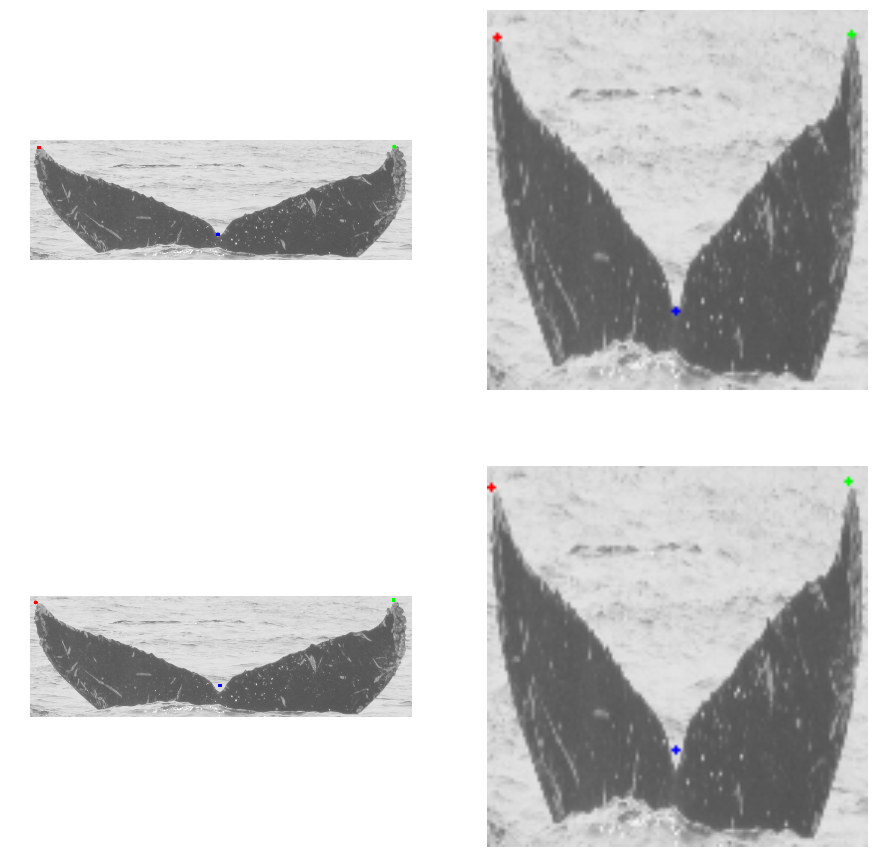

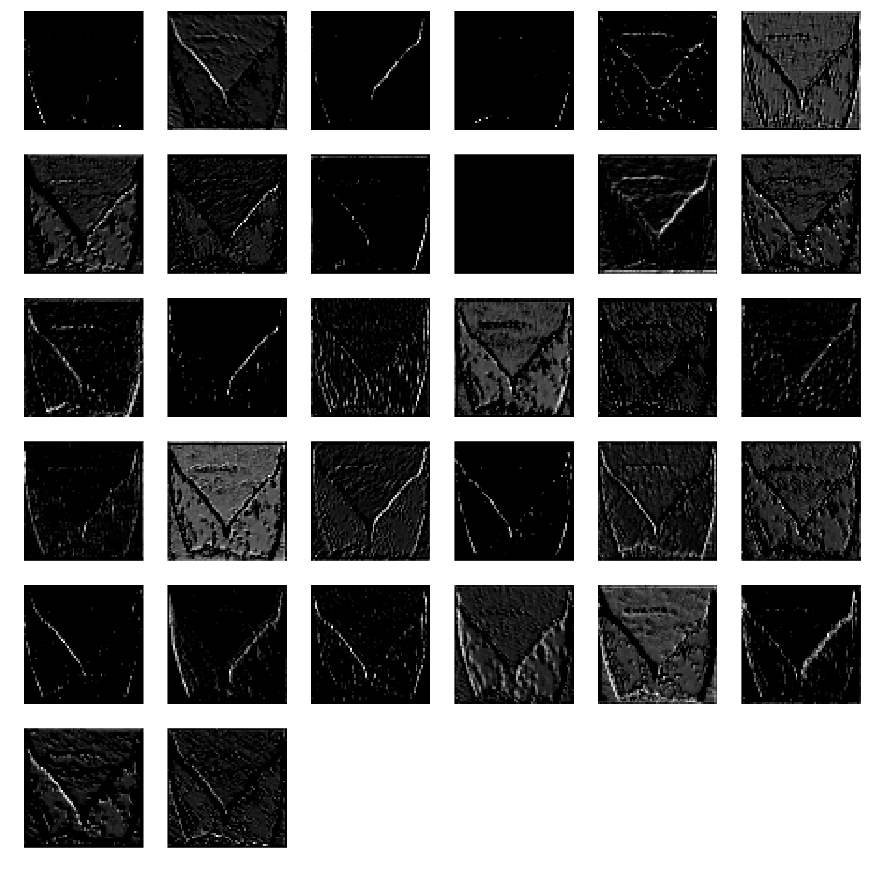

In [8]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def drawPoints(points, img, radius=5):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (int(points[0,0]), int(points[0,1])), radius, (255,0,0), -1) # left
    cv2.circle(color_img, (int(points[1,0]), int(points[1,1])), radius, (0,255,0), -1) # right
    cv2.circle(color_img, (int(points[2,0]), int(points[2,1])), radius, (0,0,255), -1) # notch
    return color_img

def show_output(originals, true_labels, outputs, ind, stage=-1, imgnames=None, sizes=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dsety, dsetx = dset_img.shape[:2]
    true_points = true_labels[ind]
    imgname = imgnames[ind]
    print(imgname)
    original_img = cv2.cvtColor(cv2.imread(imgname),cv2.COLOR_BGR2GRAY)
    if sizes is not None:
        original_img = cv2.resize(original_img, tuple(sizes[ind][::-1]), cv2.INTER_LANCZOS4)
    print(original_img.shape)
    origy, origx = original_img.shape[:2]
    #sizey, sizex = original.shape[-2:]
    sizey, sizex = (1.,1.)
    scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.array([origx, origy]*3,dtype=np.float32).reshape(3,2)
    scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_points * (scale_num_orig / scale_denom)
    true_points_dset = true_points * (scale_num_dset / scale_denom)
    print(true_points_orig)
    print(true_points_dset)
    #true_points_scaled = (true_points * scale_mat + scale_mat) / 2 
    # draw left right notch on the original image
    orig_gt_drawn = drawPoints(true_points_orig, original_img)
    dset_gt_drawn = drawPoints(true_points_dset, dset_img, radius=1)
    
    pred_points = outputs[-1][ind]
    #pred_points_scaled = (pred_points * scale_mat + scale_mat) / 2
    pred_points_orig = pred_points * (scale_num_orig / scale_denom)
    pred_points_dset = pred_points * (scale_num_dset / scale_denom)
    print(pred_points_orig)
    print(pred_points_dset)
    pred_drawn_orig = drawPoints(pred_points_orig, original_img)
    pred_drawn_dset = drawPoints(pred_points_dset, dset_img, radius=1)
    print(np.linalg.norm(true_points_orig - pred_points_orig, axis=1))
    print(np.linalg.norm(true_points_dset - pred_points_dset, axis=1))
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(orig_gt_drawn)
    trueax[0,1].imshow(dset_gt_drawn)
    trueax[1,0].imshow(pred_drawn_orig)
    trueax[1,1].imshow(pred_drawn_dset)
    
    nfilters = network_stage.shape[-1]
    #print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    if square_size > 1:
        f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
        for i in range(square_size*square_size):
            #netax.set_gray()
            this_ax = netax[i // square_size, i % square_size]
            this_ax.axis('off')
            #this_ax.get_xaxis().set_visible(False)
            #this_ax.get_yaxis().set_visible(False)
            if i < nfilters:
                this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    else:
        # probably an input or stn
        #print(network_stage[:,:,0])
        print(outputs[stage-1][ind].reshape(2,3))
        denormed =  (dset['std']*network_stage[:,:,0] + dset['mean']).astype(np.uint8).T
        #denormed = network_stage[:,:,0].astype(np.uint8)
        #print(denormed)

        f, netax = plt.subplots(1, figsize=(7.5,7.5))
        netax.axis('off')
        netax.imshow(denormed, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'test'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=4, 
            imgnames=dset_for_model[sec]['names'], sizes=dset_for_model[sec]['extra'])

[[ 0.065752    0.14095853]
 [ 0.92283714  0.14325482]
 [ 0.49169362  0.51416898]]
[[ 0.06323394  0.14161974]
 [ 0.92252302  0.14026278]
 [ 0.49176517  0.51108277]]
0.0229304
0.0891936
0.0986617


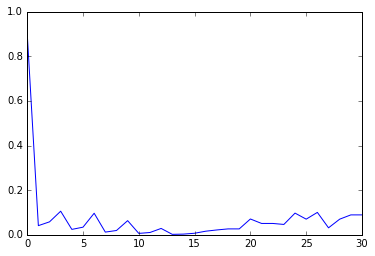

In [9]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])
avg_prediction = np.average(dset_for_model[sec]['y'],axis=0)
print(avg_prediction)
print(np.average(point_outputs[sec][-1],axis=0))
def eucl_loss(pred, y):
    return np.average(np.linalg.norm(pred - y, axis=2),axis=(0,1))

print(eucl_loss(point_outputs[sec][-1], dset_for_model[sec]['y']))
print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

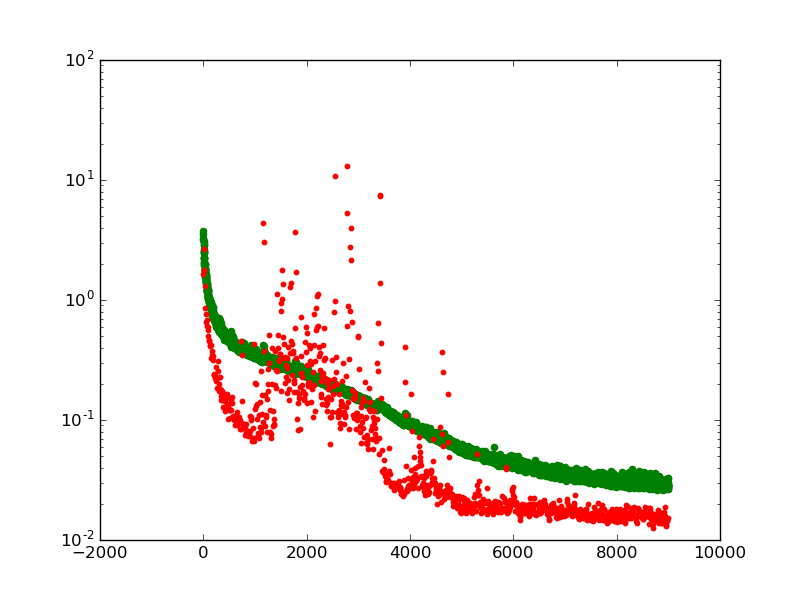

In [10]:
from IPython.display import Image 
Image(filename='./losses.png')

In [11]:
# let's see the worst cases by original size
sec = 'test'
def get_gt_dist(true_pt, pred_pt, sizes):
    #sizey, sizex = (1.,1.)
    sizes = sizes[:,::-1]
    #scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.stack([sizes, sizes, sizes],axis=1).astype(np.float32)
    #scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_pt * (scale_num_orig)
    #true_points_dset = true_points * (scale_num_dset / scale_denom)
    pred_points_orig = pred_pt * (scale_num_orig)
    dists = np.linalg.norm(true_points_orig - pred_points_orig, axis=2)
    #print(dists)
    return dists

gt_dists = get_gt_dist(dset_for_model[sec]['y'], point_outputs[sec][-1], dset_for_model[sec]['extra'])

In [12]:
sorted_by_dist = sorted(zip(gt_dists, list(range(dset_for_model[sec]['X'].shape[0]))), key=lambda x: np.average(x[0]))
dists, ind_sorted = zip(*sorted_by_dist)
sorted_X = dset_for_model[sec]['X'][ind_sorted,:]
sorted_y = dset_for_model[sec]['y'][ind_sorted,:]
sorted_pred = [stage[ind_sorted,:] for stage in point_outputs[sec]]
sorted_names = [dset_for_model[sec]['names'][ind] for ind in ind_sorted]
sorted_sizes = dset_for_model[sec]['extra'][ind_sorted,:]

/home/zach/data/Flukes/Flukebook/images/extractca3ac822-3780-45f9-9378-59ab4c7d1a8c.jpg
(639, 960)
[[ 292.5        274.5703125]
 [ 450.         284.5546875]
 [ 390.         284.5546875]]
[[ 39.  55.]
 [ 60.  57.]
 [ 52.  57.]]
[[ 259.3999939   291.53790283]
 [ 744.07928467  370.49291992]
 [ 477.09967041  367.00552368]]
[[ 34.58666611  58.39883041]
 [ 99.21057129  74.2145462 ]
 [ 63.61328888  73.51597595]]
[  37.19555664  306.37887573  119.9353714 ]
[  5.57041883  42.82300186  20.19024277]


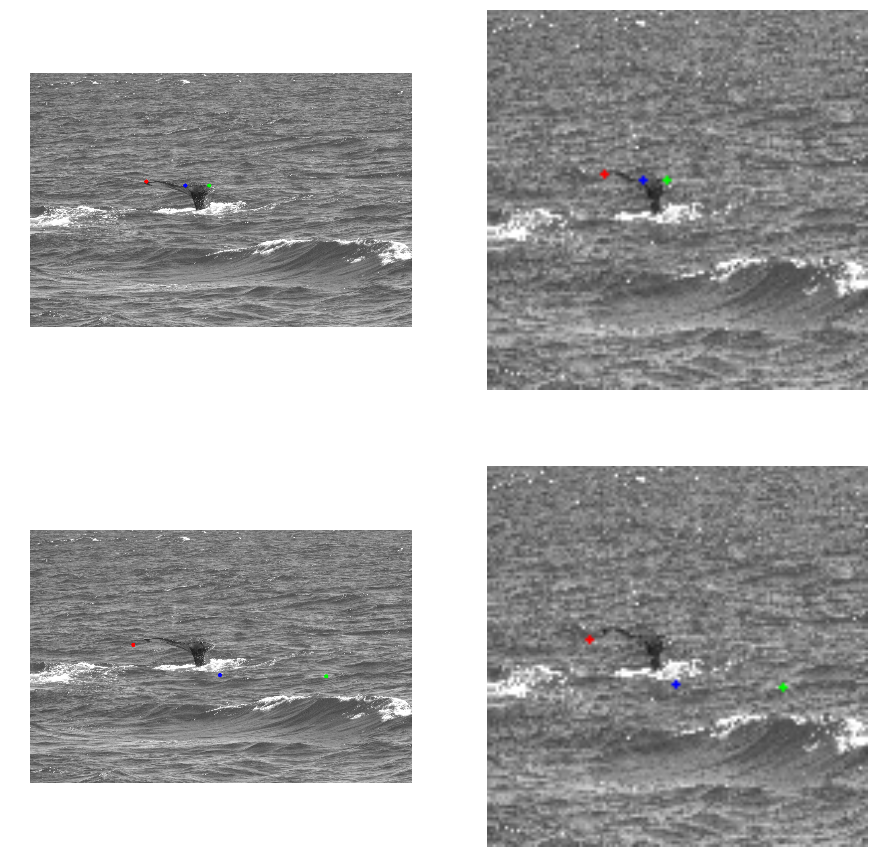

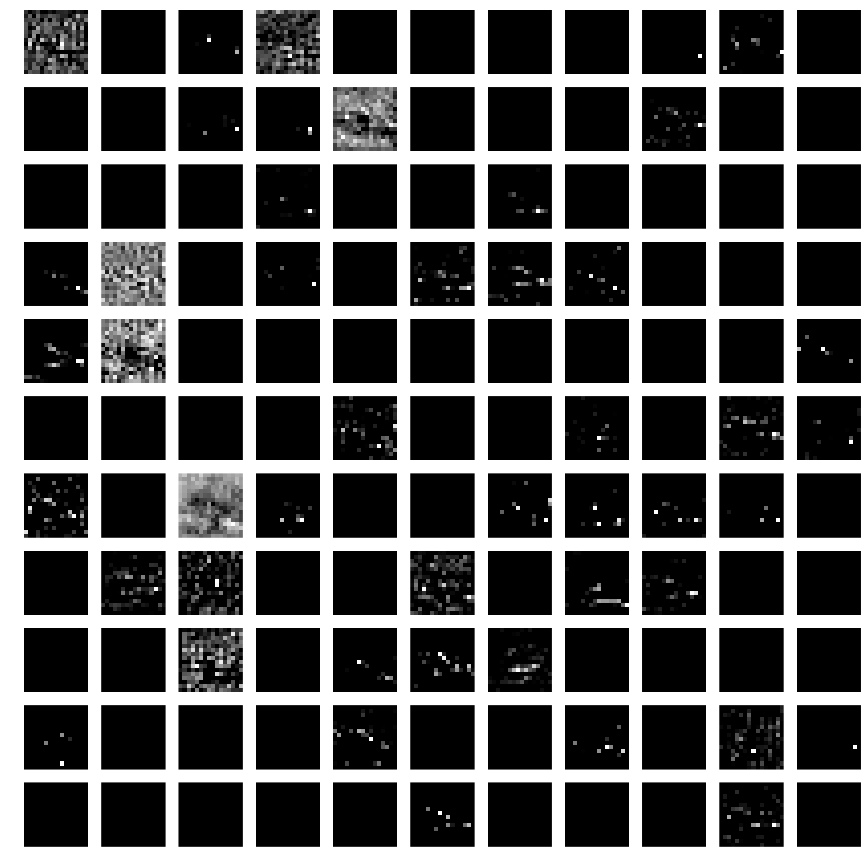

In [13]:
show_output(sorted_X, sorted_y, sorted_pred, -8, stage=10, imgnames=sorted_names, sizes=sorted_sizes)

0.134646962233


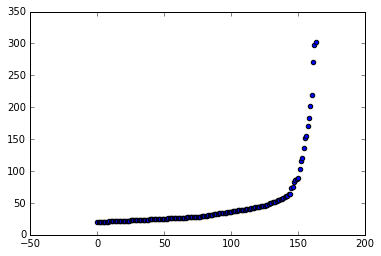

In [14]:
dists = np.vstack(dists)
dists_over = dists[np.average(dists,axis=1) > 20]
print(float(dists_over.shape[0]) / dists.shape[0])
plt.scatter(range(dists_over.shape[0]),np.average(dists_over,axis=1))

In [15]:
# Export model params and dataset so that IBEIS can use it
model_ibs = {'params':model, 'mean':dset['mean'], 'std':dset['std']}
prod_model_name = 'kpext_%s_decoupled_nofb.pickle' % size
prod_model_dir = '/media/hdd/PUBLIC/models'
ut.save_cPkl(join(prod_model_dir, prod_model_name), model_ibs)
print(model_ibs['mean'])

[util_io] * save_cPkl(u'.../models/kpext_128_decoupled_nofb.pickle', data)
147.122118334


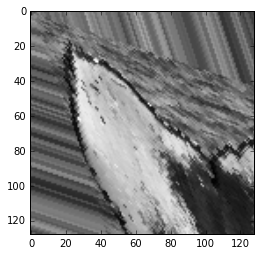

In [16]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))